In [1]:
%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.utils import * # model_to_dot, to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import *

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

SEED = 42              # seed 숫자를 지정
random.seed(SEED)     # Python 고정
np.random.seed(SEED)  # numpy 고정
tf.random.set_seed(SEED) # Tensorflow 고정

In [2]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

# df_train.head()

In [3]:
level = 'gds_grp_nm'

df_all = pd.concat([df_train, df_test])
train1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'gds_grp_mclas_nm'

df_all = pd.concat([df_train, df_test])
train2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'goods_id'

df_all = pd.concat([df_train, df_test])
train3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'store_nm'

df_all = pd.concat([df_train, df_test])
train4 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test4 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

def divide_class(x):
    
    if 4000000<= x < 8000000:
        return 200
    elif 8000000<= x < 18000000:
        return 300
    elif 18000000<= x <40000000:
        return 400
    elif 40000000<= x <60000000:
        return 500
    elif 60000000<= x <100000000:
        return 600
    elif x>= 100000000:
        return 700
    else:
        return 100

df_all = pd.concat([df_train, df_test])

train5 = pd.get_dummies(df_all.groupby('cust_id')['amount'].sum().reset_index()['amount'].agg(divide_class)).reset_index().query('index not in @IDtest').drop(columns=['index']).values
test5 = pd.get_dummies(df_all.groupby('cust_id')['amount'].sum().reset_index()['amount'].agg(divide_class)).reset_index().query('index in @IDtest').drop(columns=['index']).values

In [5]:
train6 = np.hstack([train4, train5])
test6 = np.hstack([test4, test5])

poly = PolynomialFeatures(2, interaction_only=True, include_bias = False)

train_poly = poly.fit_transform(train6)
test_poly = poly.fit_transform(test6)

# print(train_poly.shape, test_poly.shape)

X_train = np.hstack([train1, train2, train3, train_poly])
X_test = np.hstack([test1, test2, test3, test_poly])

X_train.shape, X_test.shape

((3500, 4675), (2482, 4675))

DAE learning curve


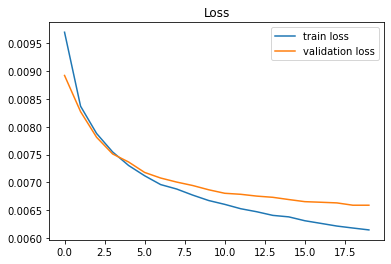

In [6]:
encoding_dim = 128

# Input Layer
input_dim = Input(shape = (X_train.shape[1], ))

# Encoder Layers
noise = Dropout(0.5)(input_dim) # for Denoising
# noise = BatchNormalization()  
encoded1 = Dense(512, activation = 'elu')(noise)
encoded2 = Dense(256, activation = 'elu')(encoded1)
encoded3 = Dense(128, activation = 'elu')(encoded2)
encoded4 = Dense(encoding_dim, activation = 'elu')(encoded3)

# Decoder Layers
decoded1 = Dense(128, activation = 'elu')(encoded4)
decoded2 = Dense(256, activation = 'elu')(decoded1)
decoded3 = Dense(512, activation = 'elu')(decoded2)
decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded4)

# Compile the model
autoencoder.compile(optimizer = 'adam', loss = 'mse')

# Train the model
history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

# print(f'DAE learning curve {i+1}/{N}')
print('DAE learning curve')
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

In [7]:
# Use a middle Bottleneck Layer to Reduce Dimension
hidden_act = [encoded4] #[encoded1, encoded2, encoded3, decoded1, decoded2]
for ix, act in enumerate(hidden_act):
    model = Model(inputs=input_dim, outputs=act)
    if ix == 0: 
        X_train = model.predict(X_train)
        X_test = model.predict(X_test)
    else:
        X_train = np.hstack([X_train, model.predict(train)])
        X_test = np.hstack([X_test, model.predict(test)])
        
X_train.shape, X_test.shape

((3500, 128), (2482, 128))

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

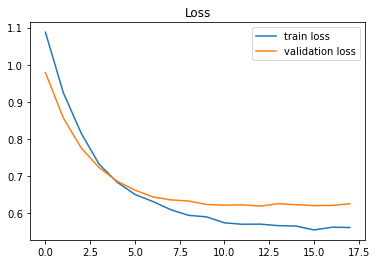

  5%|████▏                                                                              | 1/20 [00:02<00:55,  2.92s/it]

Val_AUC 0.7155615790936892 AUC 0.7967897572285869


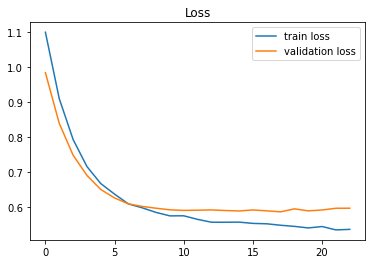

 10%|████████▎                                                                          | 2/20 [00:07<01:04,  3.56s/it]

Val_AUC 0.7527453433416736 AUC 0.7532477495908347


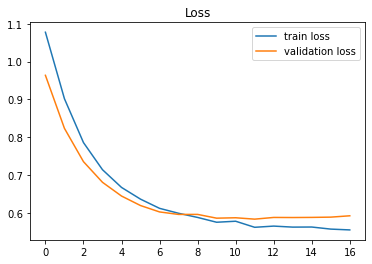

 15%|████████████▍                                                                      | 3/20 [00:12<01:04,  3.80s/it]

Val_AUC 0.7477064220183487 AUC 0.7587459083469722


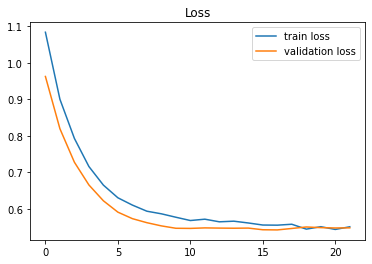

 20%|████████████████▌                                                                  | 4/20 [00:17<01:05,  4.12s/it]

Val_AUC 0.7960800667222686 AUC 0.7333435624659029


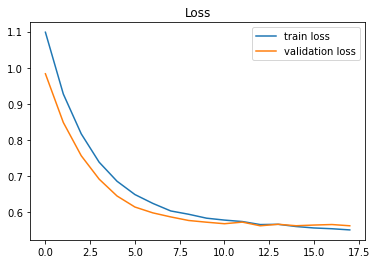

 25%|████████████████████▊                                                              | 5/20 [00:21<01:00,  4.04s/it]

Val_AUC 0.7860369752571588 AUC 0.739975450081833


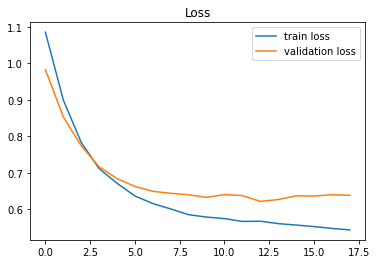

 30%|████████████████████████▉                                                          | 6/20 [00:24<00:55,  3.97s/it]

Val_AUC 0.7027036419238254 AUC 0.7625988816148391


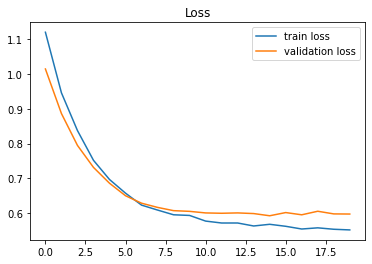

 35%|█████████████████████████████                                                      | 7/20 [00:29<00:52,  4.04s/it]

Val_AUC 0.7380803447317209 AUC 0.762223813420622


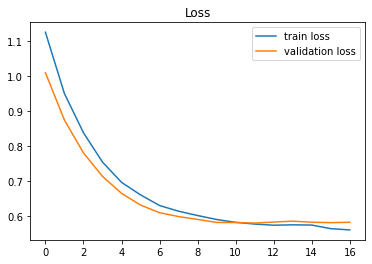

 40%|█████████████████████████████████▏                                                 | 8/20 [00:32<00:47,  4.00s/it]

Val_AUC 0.7663678065054212 AUC 0.7919223949809056


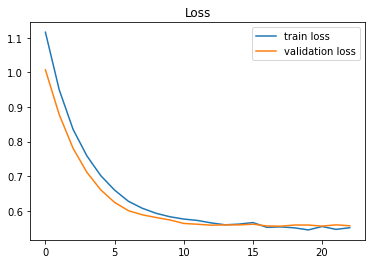

 45%|█████████████████████████████████████▎                                             | 9/20 [00:37<00:45,  4.16s/it]

Val_AUC 0.7901376146788991 AUC 0.7353723404255319


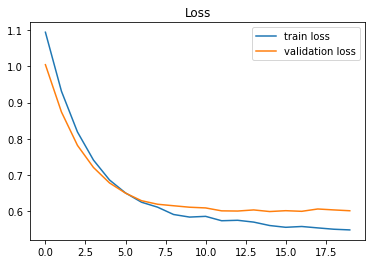

 50%|█████████████████████████████████████████                                         | 10/20 [00:41<00:42,  4.21s/it]

Val_AUC 0.734257714762302 AUC 0.7762036279323514


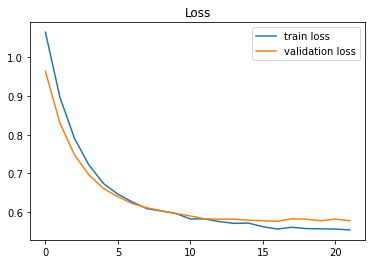

 55%|█████████████████████████████████████████████                                     | 11/20 [00:46<00:38,  4.26s/it]

Val_AUC 0.761467889908257 AUC 0.7678242635024549


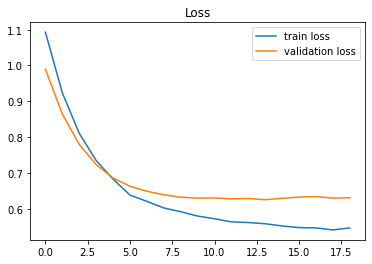

 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:50<00:33,  4.16s/it]

Val_AUC 0.7164998609952737 AUC 0.7187329514457175


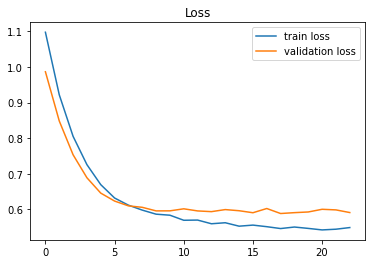

 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:55<00:30,  4.41s/it]

Val_AUC 0.7507297748123436 AUC 0.7339743589743589


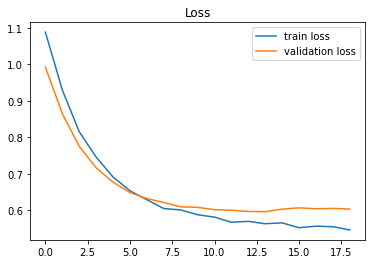

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:59<00:25,  4.26s/it]

Val_AUC 0.740130664442591 AUC 0.750801282051282


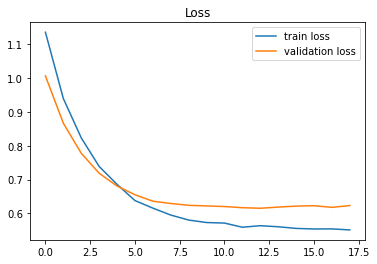

 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:03<00:21,  4.21s/it]

Val_AUC 0.7196622185154296 AUC 0.731084629023459


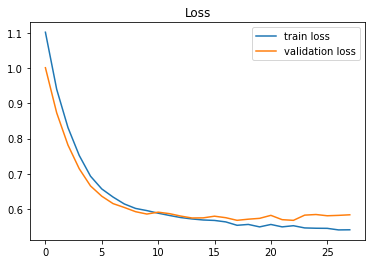

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [01:08<00:18,  4.61s/it]

Val_AUC 0.7753683625243258 AUC 0.7808152618657939


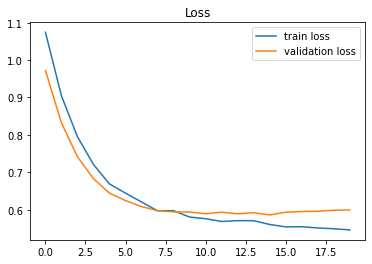

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [01:12<00:13,  4.52s/it]

Val_AUC 0.7450653322212955 AUC 0.7614736770321876


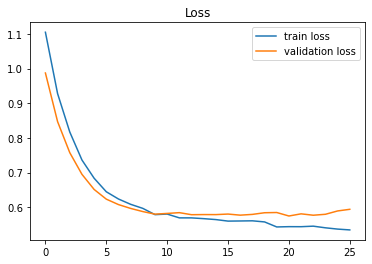

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [01:18<00:09,  4.69s/it]

Val_AUC 0.7602515985543508 AUC 0.7397367703218767


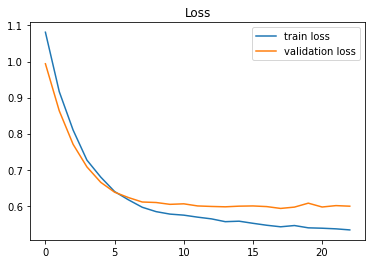

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [01:22<00:04,  4.67s/it]

Val_AUC 0.748575201556853 AUC 0.7221085651936715


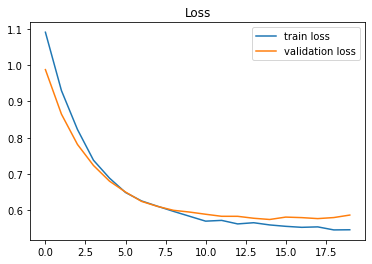

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:26<00:00,  4.34s/it]

Val_AUC 0.7626841812621629 AUC 0.7420383251500273

Validation Summary:
3     0.796080
8     0.790138
4     0.786037
15    0.775368
7     0.766368
19    0.762684
10    0.761468
17    0.760252
1     0.752745
12    0.750730
18    0.748575
2     0.747706
16    0.745065
13    0.740131
6     0.738080
9     0.734258
14    0.719662
11    0.716500
0     0.715562
5     0.702704
dtype: float64 0     0.796790
7     0.791922
15    0.780815
9     0.776204
10    0.767824
5     0.762599
6     0.762224
16    0.761474
2     0.758746
1     0.753248
13    0.750801
19    0.742038
4     0.739975
17    0.739737
8     0.735372
12    0.733974
3     0.733344
14    0.731085
18    0.722109
11    0.718733
dtype: float64
mean=0.75295, std=0.022


In [14]:
# Set hyper-parameters for power mean ensemble 

N = 20
p = 3.5
preds = []
aucs = []
val_aucs = []

for i in tqdm(range(N)):   
    
    SEED = i**2          
    random.seed(SEED)       
    np.random.seed(SEED)     
    tf.random.set_seed(SEED)
    
    trn_x, tst_x, trn_y, tst_y = train_test_split(X_train, y_train, test_size = 500, stratify = y_train)
    trn_x, val_x, trn_y, val_y = train_test_split(trn_x, trn_y, test_size = 350, stratify = trn_y)
    ##### STEP 4: Build a DNN Model
    
    # Define the number of features
    max_features = trn_x.shape[1]
    
    # Define the model architecture
    
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(max_features,), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    # model.summary()

    # Train the model

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(trn_x, trn_y, epochs=100, validation_data=(val_x, val_y),
                          batch_size=64, callbacks=[EarlyStopping(patience=5)], verbose = 0)

    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    val_auc = roc_auc_score(val_y, model.predict(val_x).flatten())
    val_aucs.append(val_auc)
    
    auc = roc_auc_score(tst_y, model.predict(tst_x).flatten())
    aucs.append(auc)
    
    print('Val_AUC', val_auc, 'AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
val_aucs = pd.Series(val_aucs)
aucs = pd.Series(aucs)

print(val_aucs.sort_values(ascending=False), aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))

In [25]:
temp = pd.concat([val_aucs, aucs], axis = 1);temp

0         1
0   0.715562  0.796790
1   0.752745  0.753248
2   0.747706  0.758746
3   0.796080  0.733344
4   0.786037  0.739975
5   0.702704  0.762599
6   0.738080  0.762224
7   0.766368  0.791922
8   0.790138  0.735372
9   0.734258  0.776204
10  0.761468  0.767824
11  0.716500  0.718733
12  0.750730  0.733974
13  0.740131  0.750801
14  0.719662  0.731085
15  0.775368  0.780815
16  0.745065  0.761474
17  0.760252  0.739737
18  0.748575  0.722109
19  0.762684  0.742038

In [30]:
temp.sort_values(by = 1, ascending=False).head(15)

0         1
0   0.715562  0.796790
7   0.766368  0.791922
15  0.775368  0.780815
9   0.734258  0.776204
10  0.761468  0.767824
5   0.702704  0.762599
6   0.738080  0.762224
16  0.745065  0.761474
2   0.747706  0.758746
1   0.752745  0.753248
13  0.740131  0.750801
19  0.762684  0.742038
4   0.786037  0.739975
17  0.760252  0.739737
8   0.790138  0.735372

In [35]:
pred = gmean([preds[0], preds[7], preds[15], preds[9], preds[10], preds[6]], axis = 0)

In [39]:
t = pd.Timestamp.now()
fname = "서진영_7.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'서진영_7.csv' is ready to submit.
